In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.impute import KNNImputer
from scipy.stats import zscore

laoding data and seeing basic information about data

In [3]:

df = pd.read_csv("/content/drive/MyDrive/Tasks/data.csv")
print(df.info())  # Check data types and missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   entity                10261 non-null  object 
 1   timestamp             10261 non-null  object 
 2   DOM_dem_7da           10260 non-null  float64
 3   DOM_dem_7da_mean      428 non-null    float64
 4   RTO_dem_7da           9900 non-null   float64
 5   Solar_2da             9865 non-null   float64
 6   Solar_btm_2da         9867 non-null   float64
 7   Solar_2da_mean        413 non-null    float64
 8   Solar_btm_2da_mean    413 non-null    float64
 9   Wind_2da              9854 non-null   float64
 10  Wind                  10195 non-null  float64
 11  Solar                 10197 non-null  float64
 12  Other_renewables      10195 non-null  float64
 13  Oil                   10194 non-null  float64
 14  Storage               10197 non-null  float64
 15  Coal               

basic statistical information about the dataset

In [4]:
print(df.describe())

        DOM_dem_7da  DOM_dem_7da_mean    RTO_dem_7da     Solar_2da  \
count  10260.000000        428.000000    9900.000000   9865.000000   
mean   14562.600780      14565.551640   93344.150202   1986.715877   
std     2550.678266       2064.391964   16397.387115   2639.880591   
min    10003.000000      11179.000000   62399.000000      0.000000   
25%    12642.000000      12874.791670   81738.250000      0.000000   
50%    14089.000000      14187.208335   90713.500000     99.669000   
75%    16133.250000      15953.052083  103025.000000   3988.386000   
max    24957.000000      21709.125000  153133.000000  11065.208000   

       Solar_btm_2da  Solar_2da_mean  Solar_btm_2da_mean      Wind_2da  \
count    9867.000000      413.000000          413.000000   9854.000000   
mean     1241.869011     1986.590759         1240.616239   3667.517430   
std      1762.275064      909.085911          601.645980   2328.675397   
min      -207.900000        0.000000            0.000000     49.223000   

Remove duplicate rows.

If data collection has redundancy, which can bias results.

In [5]:
df = df.drop("entity", axis=1)
df.drop_duplicates(inplace=True)


 Ensure timestamps are in datetime format for proper time-series analysis

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

,0
timestamp,datetime64[ns]
DOM_dem_7da,float64
DOM_dem_7da_mean,float64
RTO_dem_7da,float64
Solar_2da,float64
Solar_btm_2da,float64
Solar_2da_mean,float64
Solar_btm_2da_mean,float64
Wind_2da,float64
Wind,float64


Identify and deal with missing values using imputation or removal.
both count and percentage

In [7]:
missing_values = df.isnull().sum()
print(missing_values)

timestamp                  0
DOM_dem_7da                1
DOM_dem_7da_mean        9833
RTO_dem_7da              361
Solar_2da                396
Solar_btm_2da            394
Solar_2da_mean          9848
Solar_btm_2da_mean      9848
Wind_2da                 407
Wind                      66
Solar                     64
Other_renewables          66
Oil                       67
Storage                   64
Coal                      68
Gas                       69
Hydro                     67
Nuclear                   69
multiple_fuels            66
DomPlannedOutage        9833
DomForcedOutage         9833
DomMaintenanceOutage    9833
DomTotalOutage          9833
feealslike              9868
price                     14
dtype: int64


In [8]:
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)


timestamp                0.000000
DOM_dem_7da              0.009746
DOM_dem_7da_mean        95.828867
RTO_dem_7da              3.518176
Solar_2da                3.859273
Solar_btm_2da            3.839782
Solar_2da_mean          95.975051
Solar_btm_2da_mean      95.975051
Wind_2da                 3.966475
Wind                     0.643212
Solar                    0.623721
Other_renewables         0.643212
Oil                      0.652958
Storage                  0.623721
Coal                     0.662703
Gas                      0.672449
Hydro                    0.652958
Nuclear                  0.672449
multiple_fuels           0.643212
DomPlannedOutage        95.828867
DomForcedOutage         95.828867
DomMaintenanceOutage    95.828867
DomTotalOutage          95.828867
feealslike              96.169964
price                    0.136439
dtype: float64


Visualize individual variables distributions, especially price.


If there are extreme price spikes (may indicate rare events like demand surges or supply shortages).
If the price follows a normal distribution (important for probabilistic modeling).

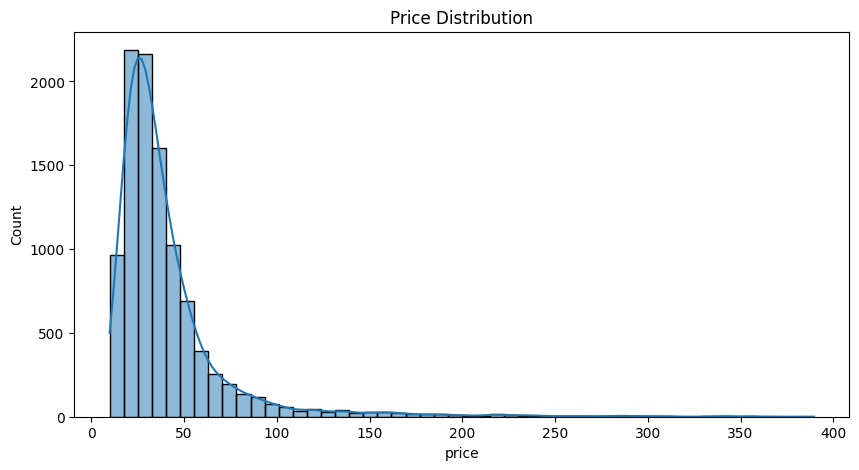

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.show()

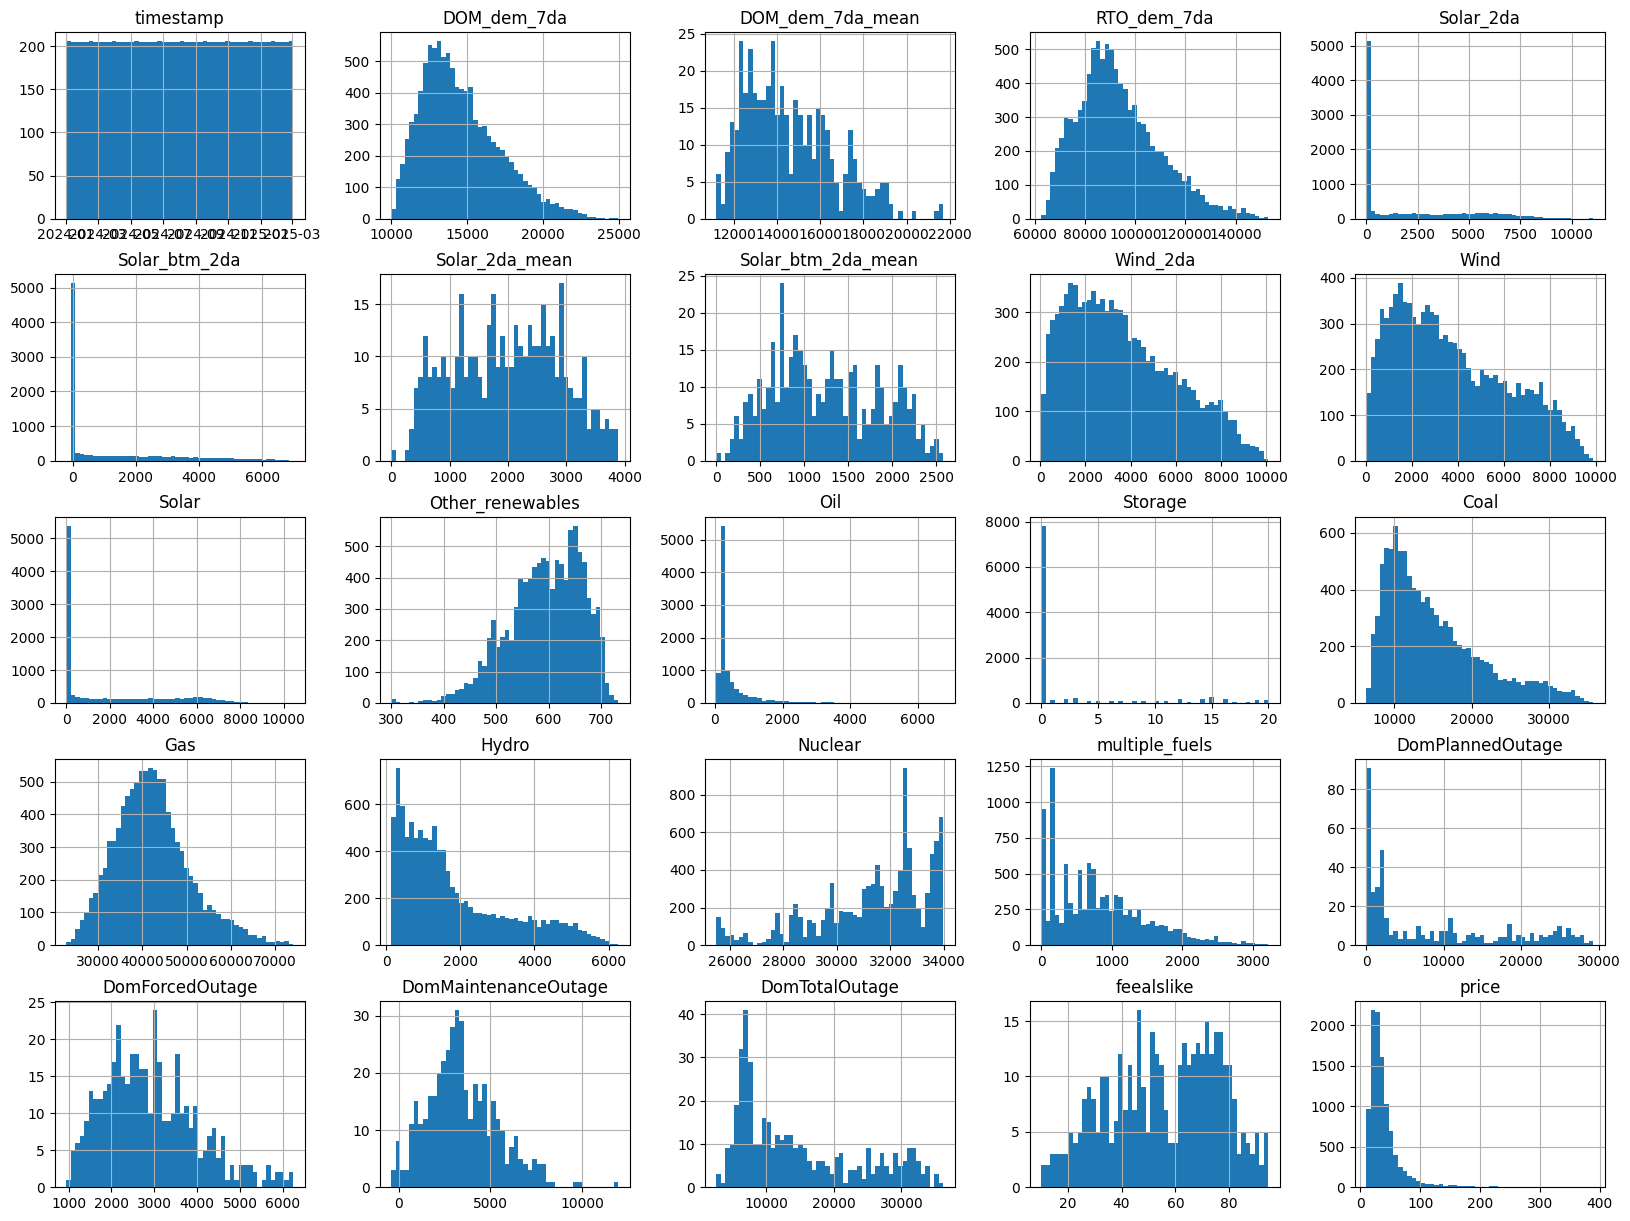

In [10]:
df.hist(figsize=(20, 15), bins=50)
plt.show()

Plot price over time and compute moving averages.
Whether price has a trend
but as we can see there is no obvious trend

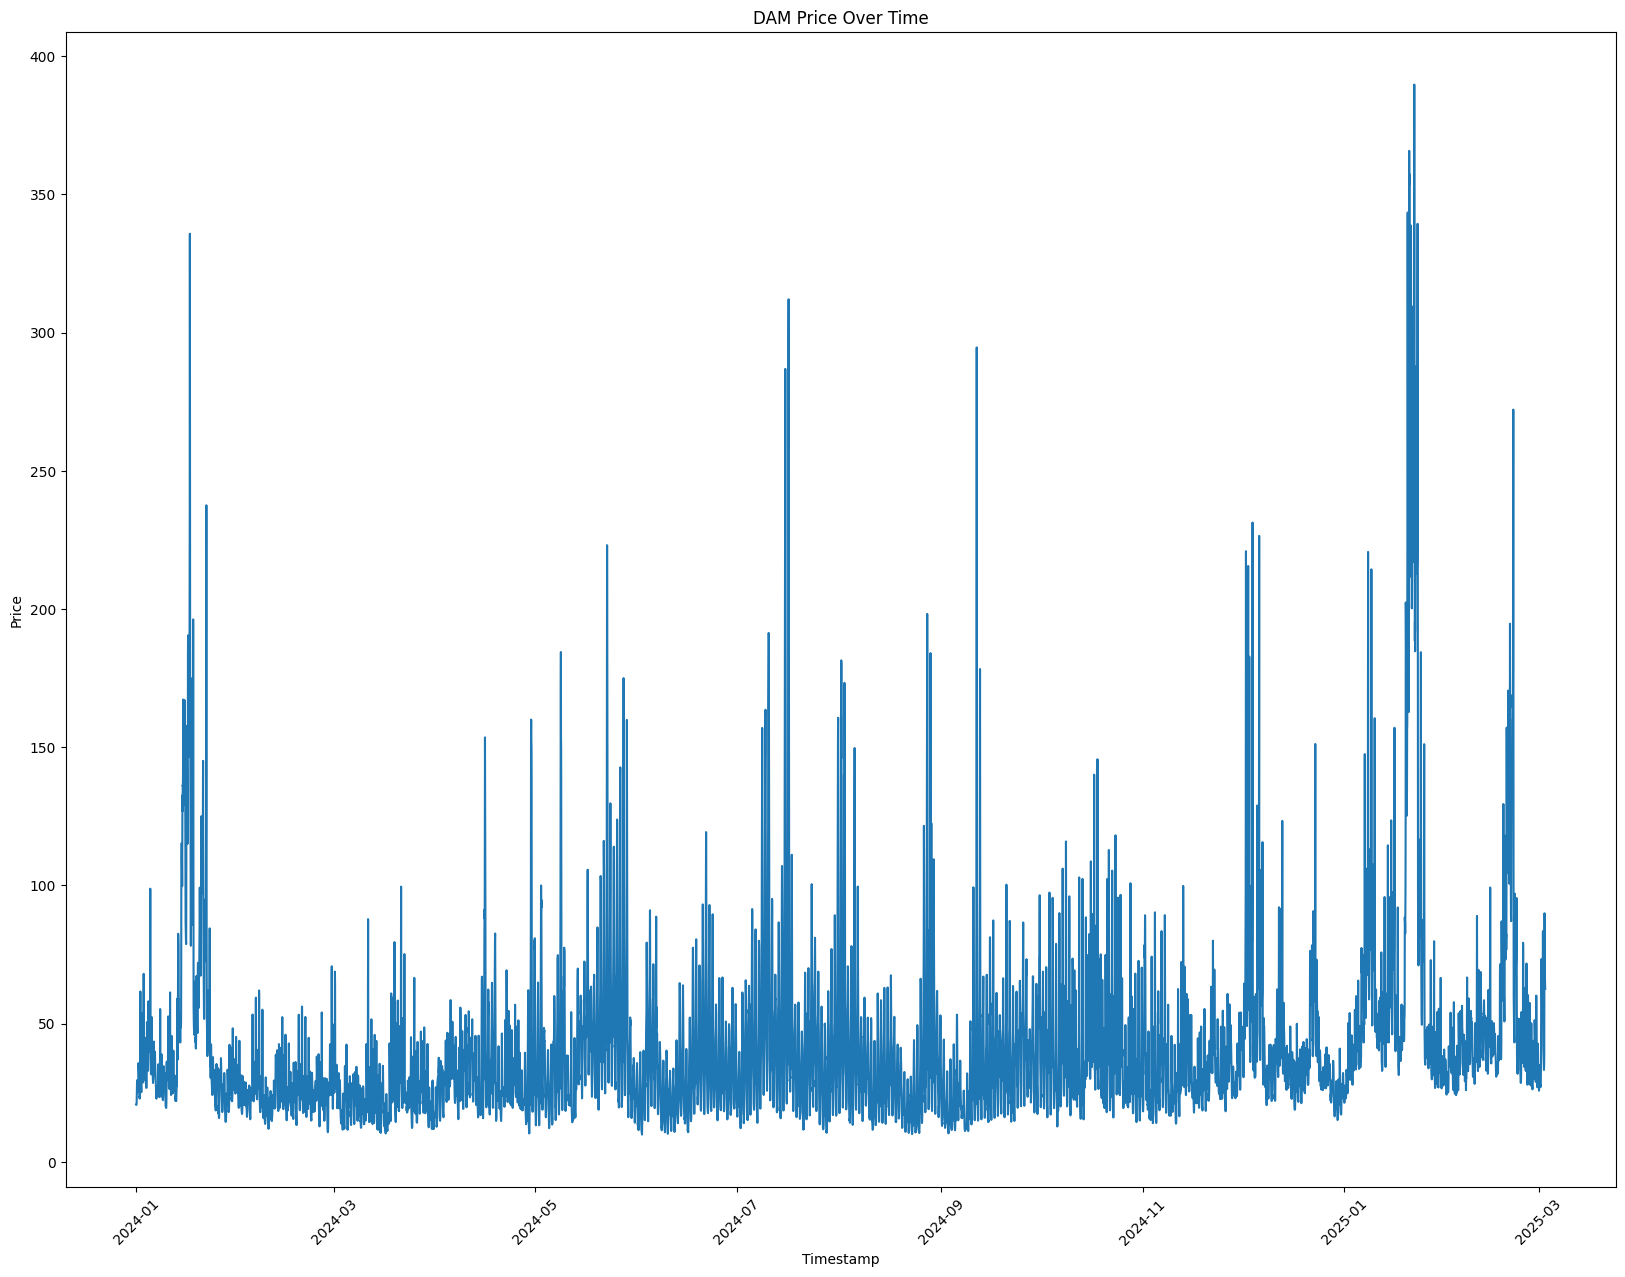

In [11]:
plt.figure(figsize=(20, 15))
plt.plot(df['timestamp'], df['price'])
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("DAM Price Over Time")
plt.xticks(rotation=45)
plt.show()

there are some rows that shows 7 days 
If some features are redundant (e.g., DOM_dem_7da_mean might be highly correlated with DOM_dem_7da).

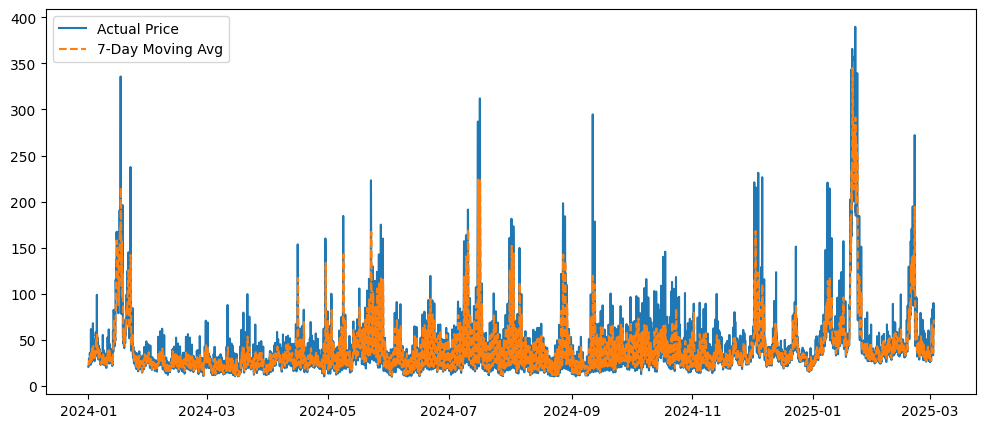

In [12]:
df['price_ma7'] = df['price'].rolling(window=7).mean()


plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['price'], label="Actual Price")
plt.plot(df['timestamp'], df['price_ma7'], label="7-Day Moving Avg", linestyle="dashed")


plt.legend()
plt.show()

Correlation Analysis
Which variables are strong predictors of price .

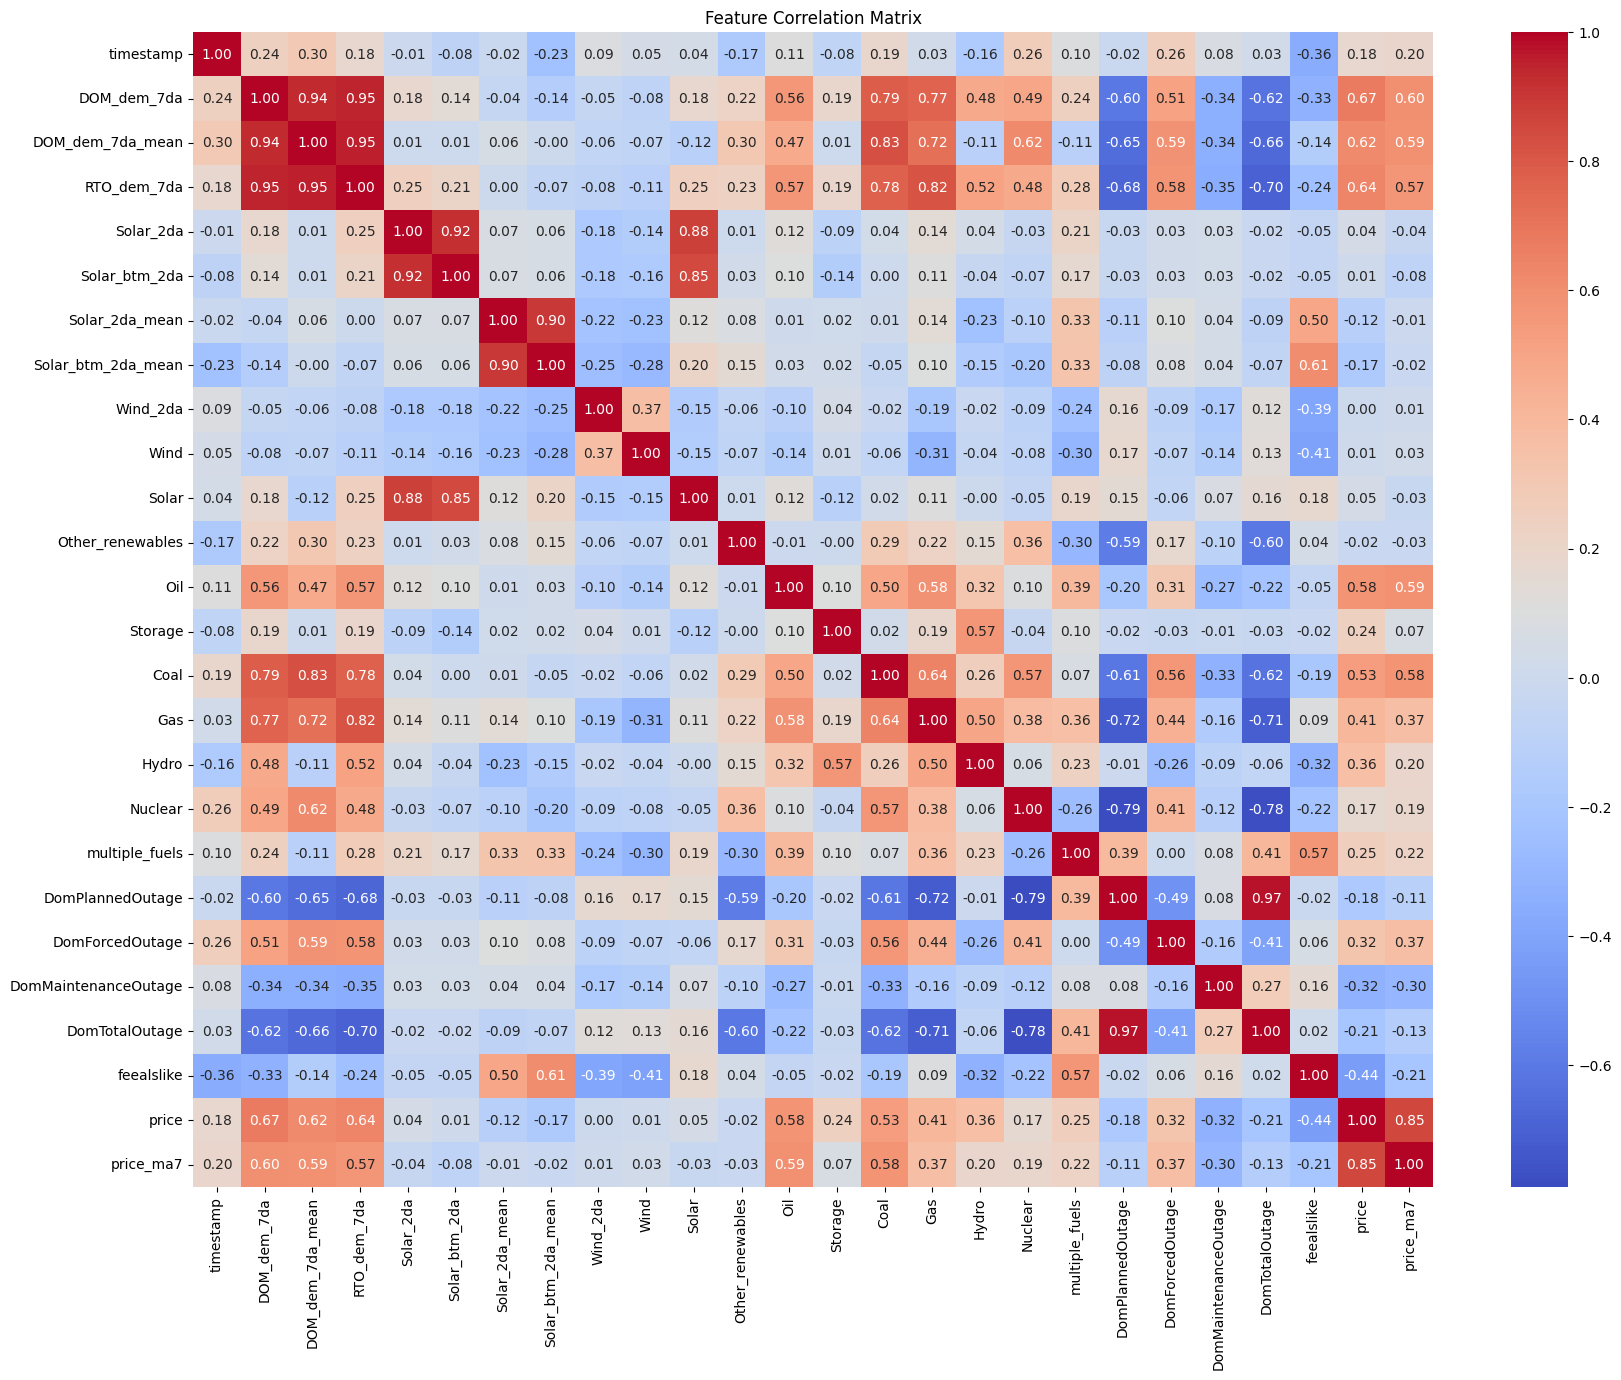

In [13]:
correlation_matrix = df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

Electricity Price Factors: The price is primarily influenced by demand (DOM_dem_7da, RTO_dem_7da) and fuel sources (Oil, Gas, Coal).
Temperature (FeelsLike) Impact: There is a negative correlation between "feelslike" temperature and both price & demand, suggesting that temperature fluctuations influence electricity usage.
Renewable Energy: Wind and solar have low or negative correlations with price, indicating that they may not be as strong of a factor in price determination as traditional energy sources.
Outages & Demand: More outages (planned or forced) tend to decrease demand measurements, likely due to supply constraints

Identify extreme values using boxplots and IQR.
If price outliers are genuine (e.g., high prices during grid failures) or data errors.

cropping outliers

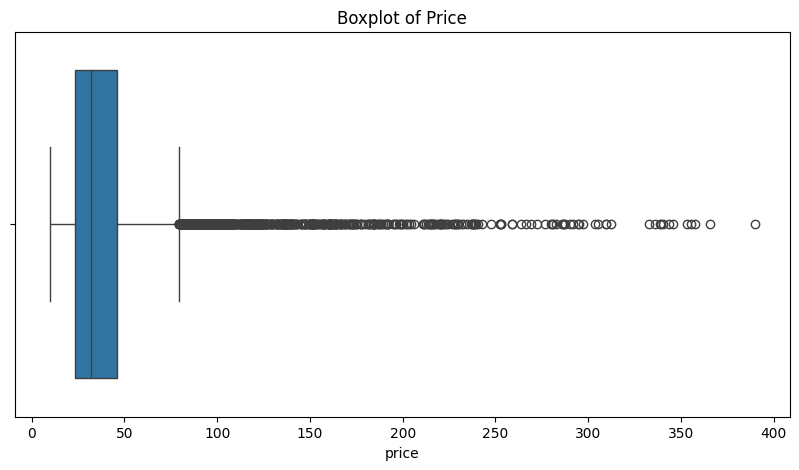

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['price'])
plt.title("Boxplot of Price")
plt.show()

In [15]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))]
print("Number of outliers:", outliers.shape[0])


Number of outliers: 751


In [16]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))]
print("Number of outliers:", outliers.shape[0])

Number of outliers: 751


In [17]:
df['price'] = df['price'].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)


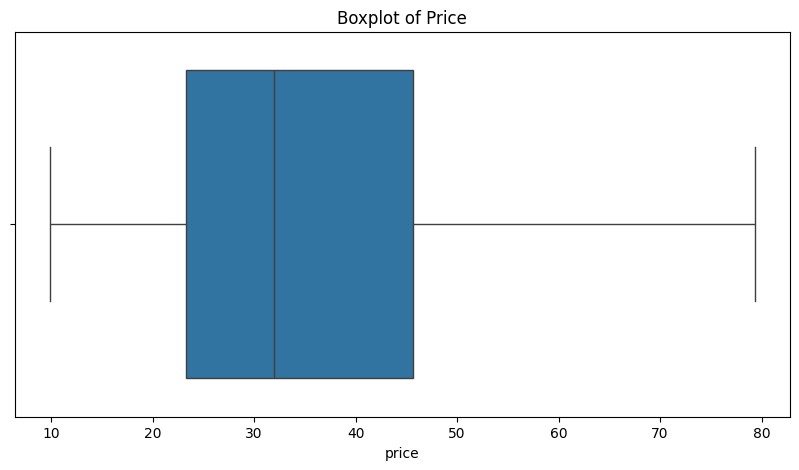

In [18]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['price'])
plt.title("Boxplot of Price")
plt.show()

What drives price changes (e.g., demand, weather, outages).
If the price follows daily or seasonal cycles.
If specific events (e.g., power outages) cause price spikes.

In [19]:
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month


as you can see there is a houly corlation 

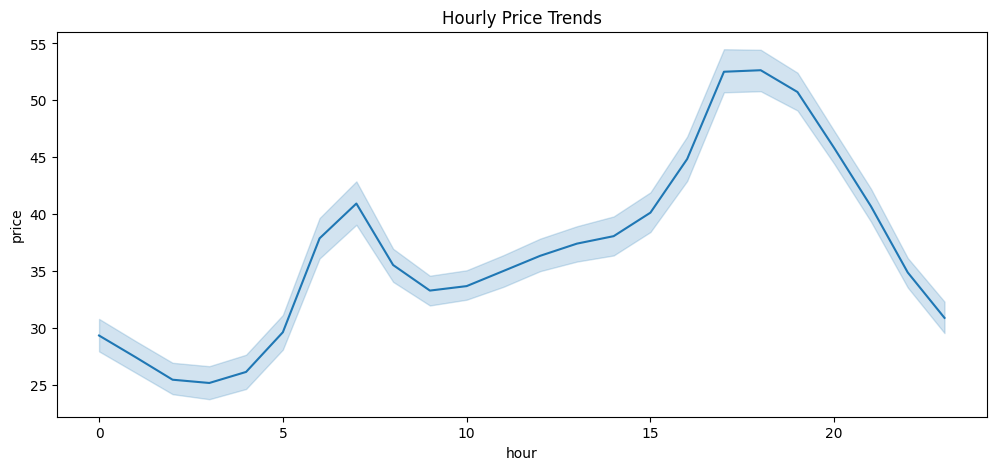

In [20]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=df["hour"], y=df["price"])
plt.title("Hourly Price Trends")
plt.show()

In [21]:
df["price_lag_1"] = df["price"].shift(1)
df["price_lag_7"] = df["price"].shift(7)


In [22]:
df["price_rolling_mean_7"] = df["price"].rolling(window=7).mean()
df["price_rolling_std_7"] = df["price"].rolling(window=7).std()


In [23]:
df["solar_to_demand_ratio"] = df["Solar"] / df["DOM_dem_7da"]
df["wind_to_total_gen"] = df["Wind"] / (df["Coal"] + df["Gas"] + df["Hydro"] + df["Nuclear"] + df["Wind"])


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              10261 non-null  datetime64[ns]
 1   DOM_dem_7da            10260 non-null  float64       
 2   DOM_dem_7da_mean       428 non-null    float64       
 3   RTO_dem_7da            9900 non-null   float64       
 4   Solar_2da              9865 non-null   float64       
 5   Solar_btm_2da          9867 non-null   float64       
 6   Solar_2da_mean         413 non-null    float64       
 7   Solar_btm_2da_mean     413 non-null    float64       
 8   Wind_2da               9854 non-null   float64       
 9   Wind                   10195 non-null  float64       
 10  Solar                  10197 non-null  float64       
 11  Other_renewables       10195 non-null  float64       
 12  Oil                    10194 non-null  float64       
 13  S

analys the coraltion between  'DOM_dem_7da', 'price'

also other high coraltion rows

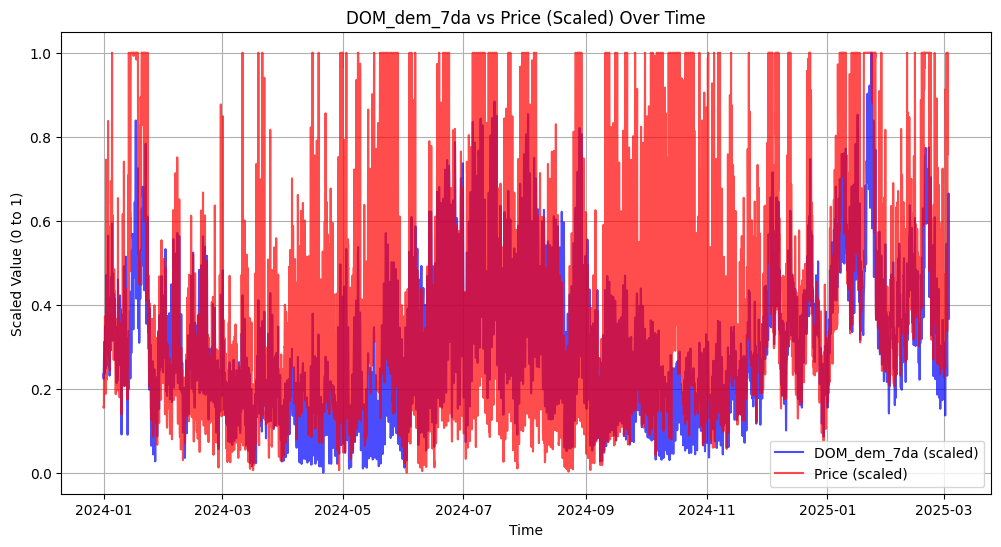

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Convert timestamp to datetime if needed
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Apply scaling
df[['DOM_dem_7da_scaled', 'price_scaled']] = scaler.fit_transform(df[['DOM_dem_7da', 'price']])

# Plot both on the same axis
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['DOM_dem_7da_scaled'], label='DOM_dem_7da (scaled)', color='b', alpha=0.7)
plt.plot(df['timestamp'], df['price_scaled'], label='Price (scaled)', color='r', alpha=0.7)

# Formatting
plt.title("DOM_dem_7da vs Price (Scaled) Over Time")
plt.xlabel("Time")
plt.ylabel("Scaled Value (0 to 1)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

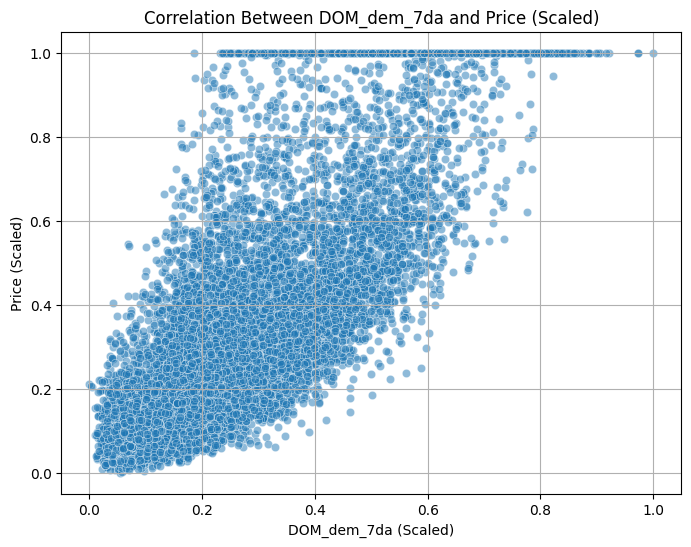

In [26]:
scaler = MinMaxScaler()

# Scale the two columns
df[['DOM_dem_7da_scaled', 'price_scaled']] = scaler.fit_transform(df[['DOM_dem_7da', 'price']])

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['DOM_dem_7da_scaled'], y=df['price_scaled'], alpha=0.5)

# Formatting
plt.title("Correlation Between DOM_dem_7da and Price (Scaled)")
plt.xlabel("DOM_dem_7da (Scaled)")
plt.ylabel("Price (Scaled)")
plt.grid(True)

# Show plot
plt.show()

# models


## XGBoost with Quantile Regression

Handles non-linear relationships well, robust to missing data, and supports feature importance analysis. and outperforms deep learning on tabular data.
By training three models (for 0.05, 0.5, and 0.95 quantiles), we can obtain uncertainty estimates directly.
Good for Small to Medium Datasets: Unlike BNNs, XGBoost doesn’t require vast amounts of data to train effectively.
Downside: Not as flexible as deep learning for capturing complex patterns.

may lose the outliers 

and as you can see in the end of this section , did not find outliers rearlly well



In [27]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib


Based on correlation analysis and domain knowledge, the best features to include for forecasting DAM (Day-Ahead Market) prices:

Use interpolation, forward-fill, backward-fill, or impute with the median/mean for continuous variables.

Remove highly correlated features (e.g., DOM_dem_7da & DOM_dem_7da_mean have 0.94 correlation). there is no need to using them all.

Ensure lagged features are correctly structured and avoid using variables with future information. give the model a sense of historical data

Resample the data at uniform intervals and fill missing timestamps with appropriate values.


In [ ]:

# Load Data
df = pd.read_csv("/content/drive/MyDrive/Tasks/data.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp")

# Fill missing values (forward-fill, then backward-fill)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Feature Engineering
def create_features(df):
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["month"] = df["timestamp"].dt.month
    
    # Lagged Features
    for lag in [1, 2, 7]:  # 1-day, 2-day, and 7-day lags
        df[f"price_lag_{lag}"] = df["price"].shift(lag)
    
    # Rolling Statistics
    df["price_ma7"] = df["price"].rolling(window=7).mean()
    df["price_ma2"] = df["price"].rolling(window=2).mean()
    
    # Drop NA values after lagging
    df.dropna(inplace=True)
    return df

df = create_features(df)

# Select features and target
features = [
    "hour", "dayofweek", "month", 
    "price_lag_1", "price_lag_2", "price_lag_7", 
    "price_ma7", "price_ma2",
    "Solar_2da", "Wind_2da", "DOM_dem_7da", "Oil","Hydro", "Coal", "Gas", "Nuclear"
]
target = "price"

# Train/Test Split (last 20% for testing)
split = int(len(df) * 0.8)
train_df, test_df = df.iloc[:split], df.iloc[split:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

X_train.to_csv("X_train.csv", index=False) 
y_train.to_csv("y_train.csv", index=False) 
X_test.to_csv("X_test.csv", index=False) 
y_test.to_csv("y_test.csv", index=False) 


# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model with Quantile Regression
def train_xgboost_quantile(X_train, y_train, quantile):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "alpha": quantile,  # Quantile loss for uncertainty estimation
        "n_estimators": 500,
        "learning_rate": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

# Train models for quantile estimation
models = {
    "p10": train_xgboost_quantile(X_train_scaled, y_train, 0.10),  # Lower bound (10th percentile)
    "p50": train_xgboost_quantile(X_train_scaled, y_train, 0.50),  # Median (50th percentile)
    "p90": train_xgboost_quantile(X_train_scaled, y_train, 0.90),  # Upper bound (90th percentile)
}

# Save models
joblib.dump(models["p10"], "xgboost_p10_model.pkl")
joblib.dump(models["p50"], "xgboost_p50_model.pkl")
joblib.dump(models["p90"], "xgboost_p90_model.pkl")

joblib.dump(scaler, "scaler.pkl")


# Make predictions
predictions = {quantile: model.predict(X_test_scaled) for quantile, model in models.items()}

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse}

print("Performance Metrics:")
for quantile, y_pred in predictions.items():
    print(f"{quantile} -> {evaluate_model(y_test, y_pred)}")



<ipython-input-33-c6cd4c159989>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-33-c6cd4c159989>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Performance Metrics:
p10 -> {'MAE': 2.9907164565238937, 'RMSE': 13.09708126468663}
p50 -> {'MAE': 3.0734831540034837, 'RMSE': 13.36193697337705}
p90 -> {'MAE': 3.0523249983864815, 'RMSE': 13.44501721171493}


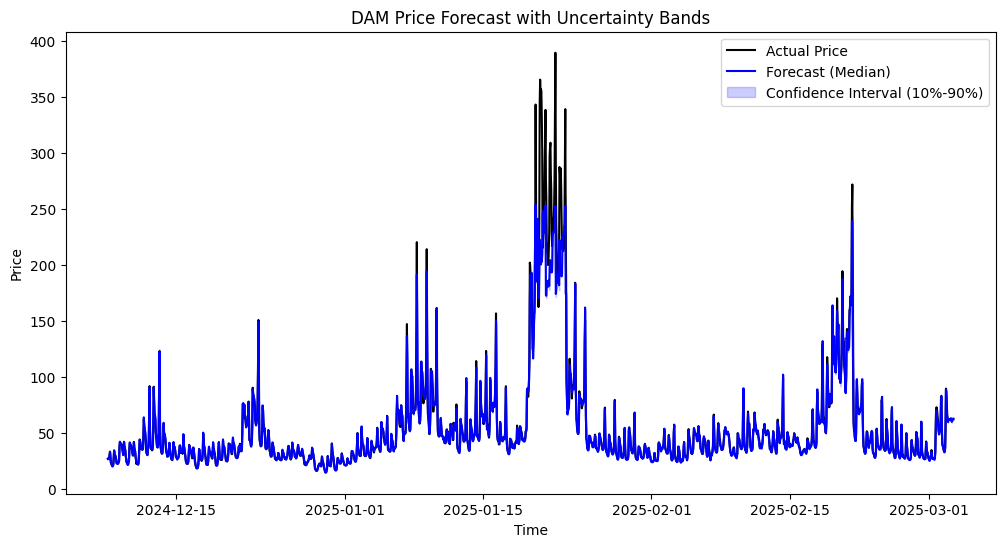

In [34]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_df["timestamp"], y_test, label="Actual Price", color="black")
plt.plot(test_df["timestamp"], predictions["p50"], label="Forecast (Median)", color="blue")
plt.fill_between(test_df["timestamp"], predictions["p10"], predictions["p90"], color="blue", alpha=0.2, label="Confidence Interval (10%-90%)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("DAM Price Forecast with Uncertainty Bands")
plt.legend()
plt.show()

## Bayesian Neural Network (BNN)

Captures Uncertainty: Unlike traditional deep learning models, BNNs provide probabilistic predictions with prediction intervals, making them ideal for DAM price forecasting.
Handles Outliers Well: Since BNNs inherently model uncertainty, they can better capture anomalies in price spikes.
Complex Relationships: Neural networks are excellent at discovering hidden non-linear relationships between inputs and outputs.


only problem may be that dataset is small for a large neural network
so must likly it will result in overfitting

the training show overfitting so I wont use this in production

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Tasks/data.csv", parse_dates=["timestamp"])
data = data.drop("entity", axis = 1)  # Adjust the file path as necessary

# Preprocessing the data
# Fill missing values with median or drop columns if needed
data.fillna(data.median(), inplace=True)

# Convert timestamp to datetime and extract features
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour

# Feature selection
features = ['DOM_dem_7da', 'Solar', 'Wind', 'Gas', 'Coal', 'Gas' 'Solar_2da', 'Wind_2da', 'day_of_week', 'hour_of_day']
target = 'price'

X = data[features]
y = data[target]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Convert to TensorFlow datasets
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Define Bayesian Neural Network model
def build_bnn():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

# Define the negative log-likelihood loss function
def nll(y_true, y_pred):
    dist = tfp.distributions.Normal(loc=y_pred, scale=1.0)  # Assuming a fixed scale for simplicity
    return -dist.log_prob(y_true)

# Define the model
model = build_bnn()

# Compile the model with a custom loss function (negative log likelihood)
model.compile(optimizer='adam', loss=nll)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Predict the price with uncertainty estimation
y_pred_mean = model(X_test)
# Here we assume the model learns the mean prediction; for uncertainty estimation, we'd use Bayesian inference

model.save('BNN_dam_model.h5')



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 667.8145 - val_loss: 698.5129
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 191.0188 - val_loss: 601.8107
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 174.2162 - val_loss: 579.4096
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 170.6226 - val_loss: 580.9108
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 146.6747 - val_loss: 595.2718
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 159.6679 - val_loss: 576.6099
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 150.8615 - val_loss: 561.4786
Epoch 8/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 146.9364 - val_loss: 569.9895
Epoch 9/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 131.3979 - val_loss: 570.8018
Epoch 10/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 133.1607 - val_loss: 561.8505
Epoch 11/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 125.2722 - val_loss: 574.9294
Epoch 12/

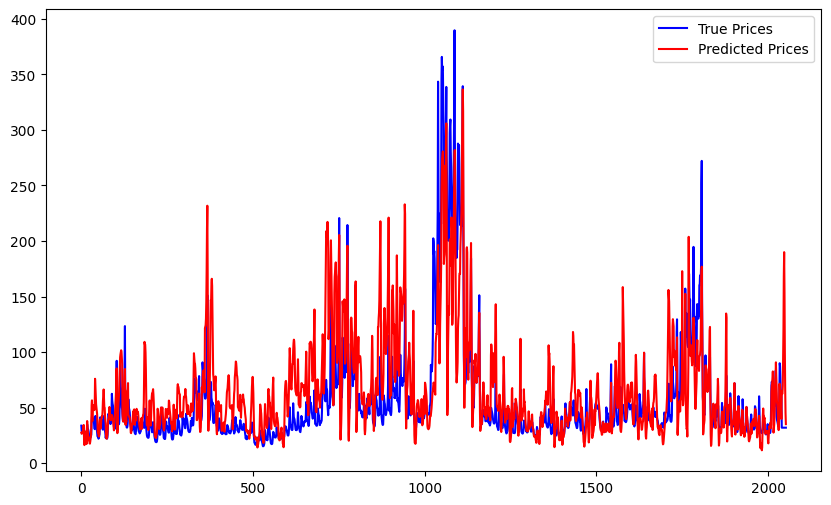

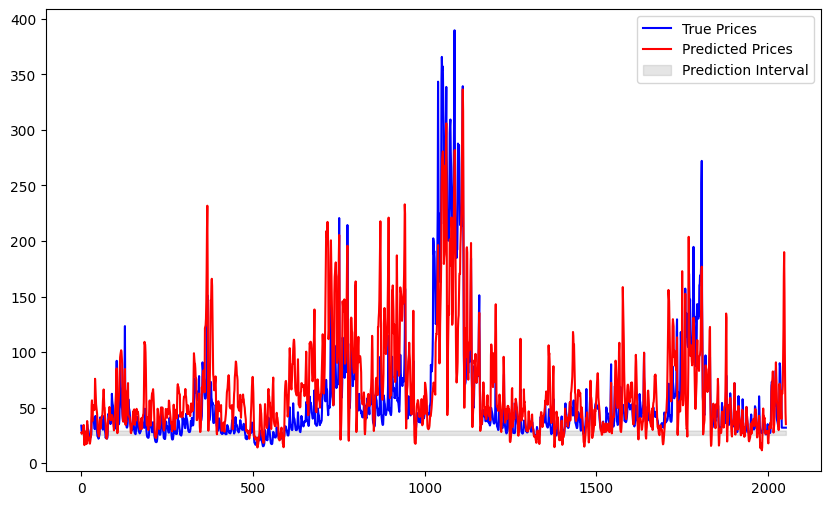

In [32]:
# Visualize the predicted vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test.numpy(), label="True Prices", color='blue')
plt.plot(y_pred_mean.numpy(), label="Predicted Prices", color='red')
plt.legend()
plt.show()

# Prediction intervals (for demonstration, use the predicted mean and fixed confidence interval)
lower_bound = y_pred_mean - 1.96
upper_bound = y_pred_mean + 1.96

# Visualize the prediction intervals
plt.figure(figsize=(10, 6))
plt.plot(y_test.numpy(), label="True Prices", color='blue')
plt.plot(y_pred_mean.numpy(), label="Predicted Prices", color='red')
plt.fill_between(range(len(y_test)), lower_bound.numpy()[0], upper_bound.numpy()[0], color='gray', alpha=0.2, label="Prediction Interval")
plt.legend()
plt.show()


this code can log in mlflow , but since I am trainnig in google colab , the logging system may not be as useful and seprate server 
but I provided some code about it 

In [ ]:
import mlflow
import mlflow.tensorflow
from mlflow.models import infer_signature


# Define MLflow experiment
mlflow.set_experiment("DAM_Price_Forecasting")

# Train the model (assuming you already have the training script)
with mlflow.start_run():
    # Model training code here (e.g., fit your neural network model)
    model.fit(X_train, y_train, epochs=5, batch_size=32)
    
    # Log model parameters
    mlflow.log_param("epochs", 50)
    mlflow.log_param("batch_size", 32)
    
    final_loss = history.history['loss'][-1]  # Final training loss
    final_val_loss = history.history['val_loss'][-1]  # Final validation loss

    # Log the model itself
    mlflow.tensorflow.log_model(model, "dam_price_forecasting_model")
    
    # Log metrics (e.g., validation loss, accuracy)
    mlflow.log_metric("validation_loss", final_val_loss)
    # mlflow.log_metric("mean_absolute_error", mean_absolute_error)
    input_example = np.array(X_train[:5])
    # Log model performance (e.g., MAE, RMSE, etc.)
    # mlflow.log_metric("rmse", rmse)

    y_pred_sample = model.predict(input_example)

    # Infer the model signature
    signature = infer_signature(input_example, y_pred_sample)

    # Log the model with the inferred signature
    mlflow.tensorflow.log_model(model, "BNN_dam_model", signature=signature)